In [1]:
%matplotlib inline

from py_wgpu_fdm import Simulation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


In [2]:
import numpy as np

COPPER_DENSITY = 8960.0  # kg / m^3

def quat_from_frame(tangent, normal, binormal):
    """
    Convert orthonormal frame to quaternion (x, y, z, w).
    Matches WGSL logic where d3 = tangent.
    """
    # R stack order: normal=d1, binormal=d2, tangent=d3
    R = np.stack([normal, binormal, tangent], axis=1)
    
    q = np.empty(4)
    tr = np.trace(R)
    if tr > 0:
        S = np.sqrt(tr + 1.0) * 2
        q[3] = 0.25 * S
        q[0] = (R[2,1] - R[1,2]) / S
        q[1] = (R[0,2] - R[2,0]) / S
        q[2] = (R[1,0] - R[0,1]) / S
    else:
        if R[0,0] > R[1,1] and R[0,0] > R[2,2]:
            S = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2
            q[3] = (R[2,1] - R[1,2]) / S
            q[0] = 0.25 * S
            q[1] = (R[0,1] + R[1,0]) / S
            q[2] = (R[0,2] + R[2,0]) / S
        elif R[1,1] > R[2,2]:
            S = np.sqrt(1.0 + R[1,1] - R[0,0] - R[2,2]) * 2
            q[3] = (R[0,2] - R[2,0]) / S
            q[0] = (R[0,1] + R[1,0]) / S
            q[1] = 0.25 * S
            q[2] = (R[1,2] + R[2,1]) / S
        else:
            S = np.sqrt(1.0 + R[2,2] - R[0,0] - R[1,1]) * 2
            q[3] = (R[1,0] - R[0,1]) / S
            q[0] = (R[0,2] + R[2,0]) / S
            q[1] = (R[1,2] + R[2,1]) / S
            q[2] = 0.25 * S
    return (q / np.linalg.norm(q)).astype(np.float32)

def generate_helical_spring_frenet(
    spring_height: float,
    windings: int,
    helix_diameter: float = 0.015,
    wire_diameter: float = 0.01,
    nodes_per_winding: int = 16, # Higher density recommended for stability
):
    R_helix = 0.5 * helix_diameter
    r_wire = 0.5 * wire_diameter
    node_count = windings * nodes_per_winding + 1
    
    # Generate helical geometry
    theta = np.linspace(0.0, 2.0 * np.pi * windings, node_count)
    h = np.linspace(0.0, spring_height, node_count)
    positions = np.stack([
        h, 
        R_helix * np.cos(theta), 
        R_helix * np.sin(theta)
    ], axis=1).astype(np.float32)

    # 1. Geometry and dx
    diffs = positions[1:] - positions[:-1]
    dx = np.linalg.norm(diffs[0])
    tangents = diffs / np.linalg.norm(diffs, axis=1, keepdims=True)

    # 2. Physics: Mass and Inertia
    area = np.pi * (r_wire**2)
    mass = float(COPPER_DENSITY * area * dx)
    I1 = (np.pi * r_wire**4) / 4.0 # Bending
    I3 = (np.pi * r_wire**4) / 2.0 # Torsion
    inertia = (COPPER_DENSITY * np.array([I1, I1, I3])).astype(np.float32)

    # 3. Build Nodes list
    nodes = [(pos, np.zeros(3, dtype=np.float32)) for pos in positions]
    
    # 4. Build Edges (Parallel Transport to minimize artificial twist)
    edges = []
    # Initial normal: avoid singularity with tangent
    t0 = tangents[0]
    up = np.array([0, 1, 0]) if abs(t0[0]) < 0.9 else np.array([0, 0, 1])
    n0 = np.cross(t0, up)
    n0 /= np.linalg.norm(n0)
    
    curr_n = n0
    for i in range(node_count - 1):
        t = tangents[i]
        b = np.cross(t, curr_n)
        b /= np.linalg.norm(b)
        n = np.cross(b, t)
        
        q = quat_from_frame(t, n, b)
        edges.append((q, np.zeros(3, dtype=np.float32)))
        curr_n = n # Transport normal to next segment

    # 5. Add Ghost Edge
    # Copy orientation of last segment to ensure zero curvature at tail
    ghost_q = edges[-1][0]
    edges.append((ghost_q, np.zeros(3, dtype=np.float32)))

    return nodes, edges, float(dx), mass, inertia

def add_center_z_velocity(
    nodes,
    dx,
    amplitude=0.05,
    width_nodes=10,
):
    """
    Deterministic transverse pluck with zero net momentum.
    """
    N = len(nodes)
    center = N // 2
    sigma = width_nodes * dx

    vz = np.zeros(N, dtype=np.float32)

    for i in range(N):
        s = (i - center) * dx
        vz[i] = amplitude * np.exp(-0.5 * (s / sigma) ** 2)

    # Remove net momentum
    vz -= vz.mean()

    for i in range(N):
        pos, vel = nodes[i]
        vel = vel.copy()
        vel[2] += vz[i]
        nodes[i] = (pos, vel)

    return nodes

    

In [3]:
import numpy as np

COPPER_DENSITY = 8960.0  # kg / m^3

def generate_straight_rod(
    rod_length: float,
    node_count: int,
    wire_diameter: float = 0.01,
    E: float = 1.1e11,   # Young's modulus [Pa]
    G: float = 4.1e10,   # Shear modulus [Pa]
):
    """
    Generate a straight Cosserat rod (nodes, edges, dx, mass, inertia)
    with shear-stretch (K_se) and bending-twist (K_bt) diagonal stiffness vectors.
    
    Conventions:
    - Tangent along the 3rd component
    - Shear in directions 1 and 2 (normal/binormal)
    - Axial along direction 3
    - Bending about 1,2 axes, torsion about 3
    """

    r_wire = 0.5 * wire_diameter

    # ------------------------------------------------------------------
    # 1. Geometry
    # ------------------------------------------------------------------
    x = np.linspace(0.0, rod_length, node_count)
    positions = np.stack([
        x,
        np.zeros_like(x),
        np.zeros_like(x),
    ], axis=1).astype(np.float32)

    dx = float(positions[1,0] - positions[0,0])

    # ------------------------------------------------------------------
    # 2. Physics: Mass and Inertia
    # ------------------------------------------------------------------
    area = np.pi * r_wire**2
    mass = float(COPPER_DENSITY * area * dx)

    I1 = (np.pi * r_wire**4) / 4.0  # bending
    I3 = (np.pi * r_wire**4) / 2.0  # torsion
    inertia = (COPPER_DENSITY * np.array([I1, I1, I3], dtype=np.float32))

    # ------------------------------------------------------------------
    # 3. Nodes
    # ------------------------------------------------------------------
    nodes = [(pos, np.zeros(3, dtype=np.float32)) for pos in positions]

    # ------------------------------------------------------------------
    # 4. Edges (constant frame, no curvature)
    # ------------------------------------------------------------------
    edges = []

    t = np.array([1.0, 0.0, 0.0], dtype=np.float32)
    n = np.array([0.0, 1.0, 0.0], dtype=np.float32)
    b = np.array([0.0, 0.0, 1.0], dtype=np.float32)

    q = quat_from_frame(t, n, b)

    for _ in range(node_count - 1):
        edges.append((q, np.zeros(3, dtype=np.float32)))
    edges.append((q, np.zeros(3, dtype=np.float32)))  # ghost edge

    # ------------------------------------------------------------------
    # 5. Shear-Stretch and Bending-Twist stiffness (diagonal)
    # ------------------------------------------------------------------
    A = area
    I = I1
    J = I3

    # Shear along 1,2; axial along tangent (3)
    K_se = np.array([G*A, G*A, E*A], dtype=np.float32)

    # Bending about 1,2; torsion about tangent (3)
    K_bt = np.array([E*I, E*I, G*J], dtype=np.float32)

    return nodes, edges, dx, mass, inertia, K_se, K_bt


In [18]:
nodes, edges, dx, mass, inertia, K_se, K_bt = generate_helical_spring_frenet(
    spring_height= 0.2,   # 5 cm
    windings=50,
    helix_diameter=0.015,
    wire_diameter=0.0010,
    nodes_per_winding=12
)

nodes = add_center_z_velocity(nodes, dx)

ValueError: not enough values to unpack (expected 7, got 5)

In [4]:
nodes, edges, dx, mass, inertia, K_se, K_bt = generate_straight_rod(0.5, 1024, wire_diameter=0.005)
nodes = add_center_z_velocity(nodes, dx, 0.5)

In [5]:
dx

0.0004887585528194904

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spring(nodes, edges, show_nodes=True):
    """
    nodes: Vec<[[x,y,z], [vx,vy,vz]]>
    edges: Vec<([qx,qy,qz,qw], [mx,my,mz])>
    """

    positions = np.array([n[0] for n in nodes])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Plot edges as a polyline
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Rod centerline",
    )

    # Plot nodes
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Axis labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_title("Discretized Helical Spring (Initial Configuration)")
    ax.legend()

    # Equal aspect ratio (important!)
    max_range = (
        np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min(),
        ]).max() / 2.0
    )

    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()


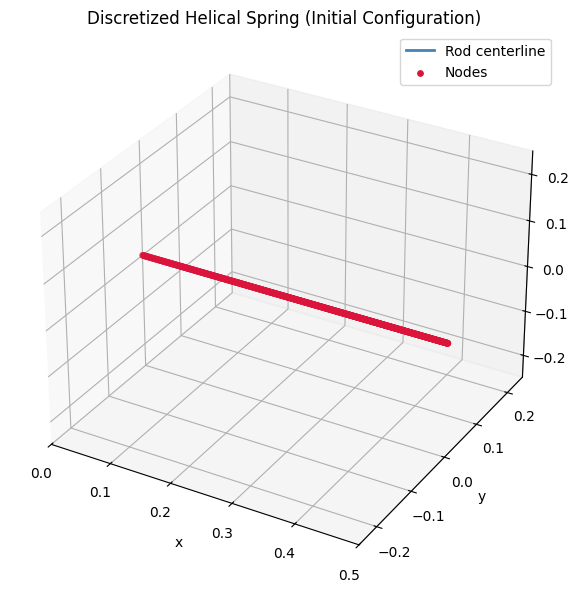

Discrete spring has 1024 nodes


In [7]:
plot_spring(nodes, edges)
print(f'Discrete spring has {len(nodes)} nodes')

In [8]:
duration = 0.1 #seconds
sample_rate = 50000
chunk_size = 512

dt = 1e-8
oversampling_factor = 1.0 / (dt * sample_rate)
print(f'The appropriate oversampling factor for a target sample rate of {sample_rate} Hz at a delta t of {dt} would be {oversampling_factor}. This yields samples that are effectively {dt * oversampling_factor} seconds apart. Therefore one chunk of {chunk_size} samples is {dt * oversampling_factor * chunk_size} long. A duration of {duration} seconds would require {duration / (dt * oversampling_factor * chunk_size)} dispatches.')
oversampling_factor = int(oversampling_factor)



The appropriate oversampling factor for a target sample rate of 50000 Hz at a delta t of 1e-08 would be 2000.0. This yields samples that are effectively 2e-05 seconds apart. Therefore one chunk of 512 samples is 0.01024 long. A duration of 0.1 seconds would require 9.765625 dispatches.


In [9]:

sim = Simulation(
    nodes=nodes,
    edges=edges,
    oversampling_factor=oversampling_factor,
    chunk_size=chunk_size,
    dt=dt,
    dx=dx,
    mass=mass,
    stiffness_se = K_se,
    stiffness_bt = K_bt,
    inertia=inertia,
)
 

In [10]:
sim.initialize(0.0, 1)

Initializing simulation!


In [ ]:
frames = list()

for i in range(1):
    sim.compute()
    f = sim.save()
    frames.extend(f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spring_from_positions(positions, show_nodes=True):
    """
    positions: array-like of shape (N, 3)
               each entry is [x, y, z]
    """

    positions = np.asarray(positions)
    assert positions.ndim == 2 and positions.shape[1] == 3

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Connect nodes
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Spring centerline",
    )

    # Optional node markers
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("Spring Configuration")

    # Equal aspect ratio (important!)
    max_range = np.ptp(positions, axis=0).max() / 2.0
    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
len(frames)

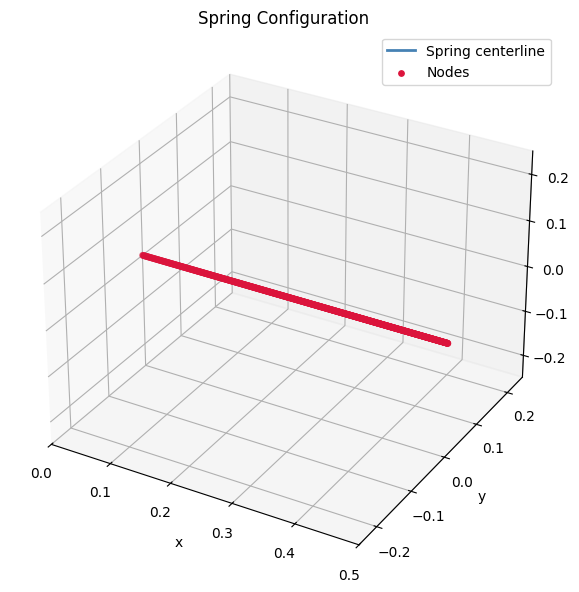

In [179]:
p = [ n[0] for n in frames[1000] ]
plot_spring_from_positions(p)

In [180]:
for f in frames:
    n = f[200]
    print(n[1])

[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[0.0, 0.0, -0.012239395640790462]
[4.568271108618127e-11, -1.199259962170185e-11, -0.0122330067679286]
[-1.4210854715202004e-14, 1.299520213660088e-11, -0.012235342524945736]
[1.1419849094140844e-10, 3.0421717228668044e-11, -0.012230775319039822]
[1.1419849094140844e-10, -5.728155103024157e-11, -0.012230775319039822]
[1.1419849094140844e-10, 3.1348534879072076e-11, -0.012232450768351555]
[1.1419849094140844e-10, 5.470097985682543e-11, -0.012234358116984367]
[1.1419849094140844e-10, -3.048011842921028e-11, -0.01223626546561718]
[5.261494573360892e-10, -

In [181]:
p[2]

[0.0009775171056389809, -1.5726566917117016e-16, -5.573994599217258e-09]

In [191]:
import numpy as np
import matplotlib.pyplot as plt

def plot_node_pos_vel_moment_fft(
    nodes_history,
    nodes0,
    dt: float,
    oversampling_factor: float,
    node_index: int | None = None,
    moments: bool = False,
):
    """
    nodes_history[t][i] = (pos, vel, moment)
    nodes0[i]           = (pos0, vel0, moment0)
    pos, vel, moment: np.ndarray (3,)
    """

    T = len(nodes_history)
    N = len(nodes_history[0])

    if node_index is None:
        node_index = N // 2

    time = np.arange(T) * dt * oversampling_factor
    freqs = np.fft.rfftfreq(T, dt * oversampling_factor)

    # ------------------------------------------------------------
    # Rest position
    # ------------------------------------------------------------
    pos0, _ = nodes0[node_index]

    # ------------------------------------------------------------
    # Extract history
    # ------------------------------------------------------------
    pos = np.zeros((T, 3), dtype=np.float32)
    vel = np.zeros((T, 3), dtype=np.float32)
    mom = np.zeros((T, 3), dtype=np.float32)

    for t in range(T):
        p, v, m = nodes_history[t][node_index]
        pos[t] = p - pos0   # displacement only
        vel[t] = v
        mom[t] = m          # absolute moment

    pos_mag = np.linalg.norm(pos, axis=1)
    vel_mag = np.linalg.norm(vel, axis=1)
    mom_mag = np.linalg.norm(mom, axis=1)

    components = [
        ("x", pos[:, 0], vel[:, 0], mom[:, 0]),
        ("y", pos[:, 1], vel[:, 1], mom[:, 1]),
        ("z", pos[:, 2], vel[:, 2], mom[:, 2]),
        ("|·|", pos_mag, vel_mag, mom_mag),
    ]

    # ------------------------------------------------------------
    # FFT helper (on displacement)
    # ------------------------------------------------------------
    def fft_mag(signal):
        fft = np.fft.rfft(signal - np.mean(signal))
        return np.abs(fft)

    # ------------------------------------------------------------
    # Plot per component
    # ------------------------------------------------------------
    for label, p_data, v_data, m_data in components:

        n_plots = 2 + int(moments)
        fig, axes = plt.subplots(
            n_plots, 1,
            figsize=(10, 2.8 * n_plots),
            sharex=False,
        )

        if n_plots == 1:
            axes = [axes]

        # ========================================================
        # 1. Displacement + Velocity (time)
        # ========================================================
        ax = axes[0]

        p_max = np.max(np.abs(p_data))
        v_max = np.max(np.abs(v_data))

        p_scaled = p_data / p_max if p_max > 0 else p_data
        v_scaled = v_data / v_max if v_max > 0 else v_data

        ax.plot(time, p_scaled, color="tab:blue")
        ax.set_ylim(-1.05, 1.05)
        ax.set_ylabel(f"{label} disp", color="tab:blue")
        ax.tick_params(axis="y", labelcolor="tab:blue")
        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([f"{-p_max:.3e}", "0", f"{p_max:.3e}"])

        ax2 = ax.twinx()
        ax2.plot(time, v_scaled, "--", color="tab:orange")
        ax2.set_ylim(-1.05, 1.05)
        ax2.set_ylabel(f"{label} vel", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        ax2.set_yticks([-1, 0, 1])
        ax2.set_yticklabels([f"{-v_max:.3e}", "0", f"{v_max:.3e}"])

        ax.set_title(f"{label} — displacement & velocity (time)")
        ax.grid(True, alpha=0.3)

        # ========================================================
        # 2. Moment (absolute, time)
        # ========================================================
        plot_idx = 1
        if moments:
            axm = axes[plot_idx]

            m_max = np.max(np.abs(m_data))
            m_scaled = m_data / m_max if m_max > 0 else m_data

            axm.plot(time, m_scaled, color="tab:green")
            axm.set_ylim(-1.05, 1.05)
            axm.set_ylabel(f"{label} moment")
            axm.set_yticks([-1, 0, 1])
            axm.set_yticklabels([f"{-m_max:.3e}", "0", f"{m_max:.3e}"])
            axm.set_title(f"{label} — moment (time)")
            axm.grid(True, alpha=0.3)

            plot_idx += 1

        # ========================================================
        # 3. FFT of displacement
        # ========================================================
        axf = axes[plot_idx]
        axf.plot(freqs, fft_mag(p_data), color="tab:blue")
        axf.set_ylabel("FFT |disp|")
        axf.set_xlabel("Frequency [Hz]")
        axf.set_title(f"{label} — displacement FFT")

        # Limit FFT plot to 20 kHz
        axf.set_xlim(0, 20000)  # Limit frequency to 20kHz
        axf.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


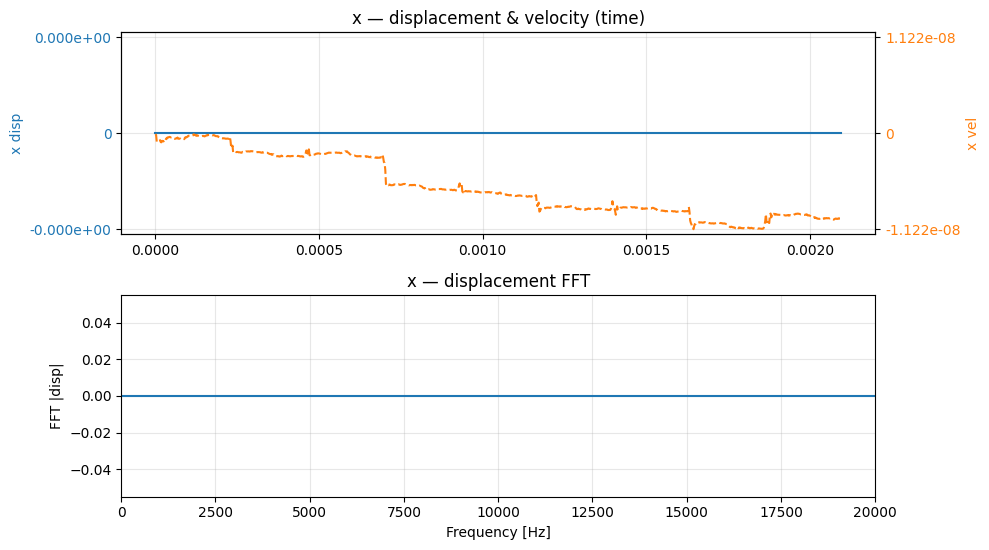

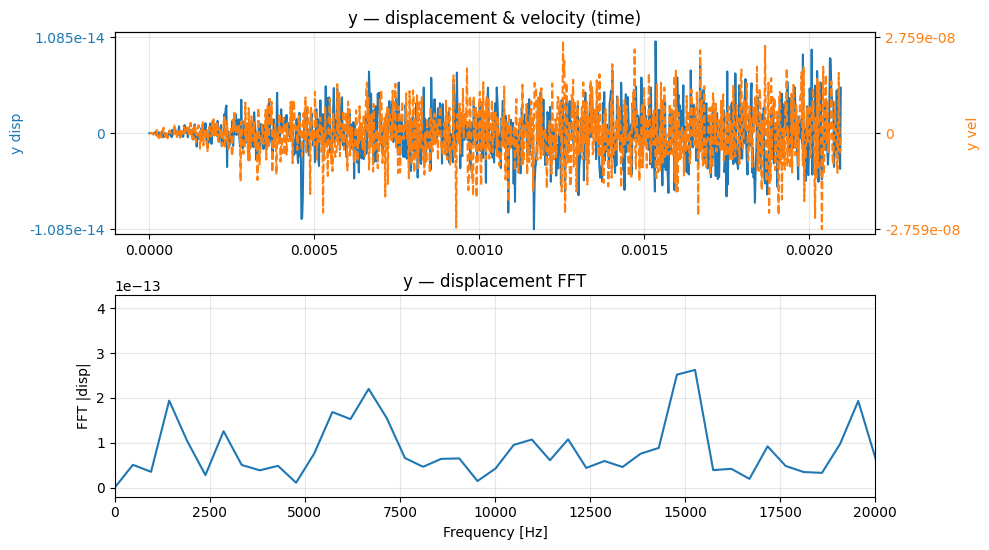

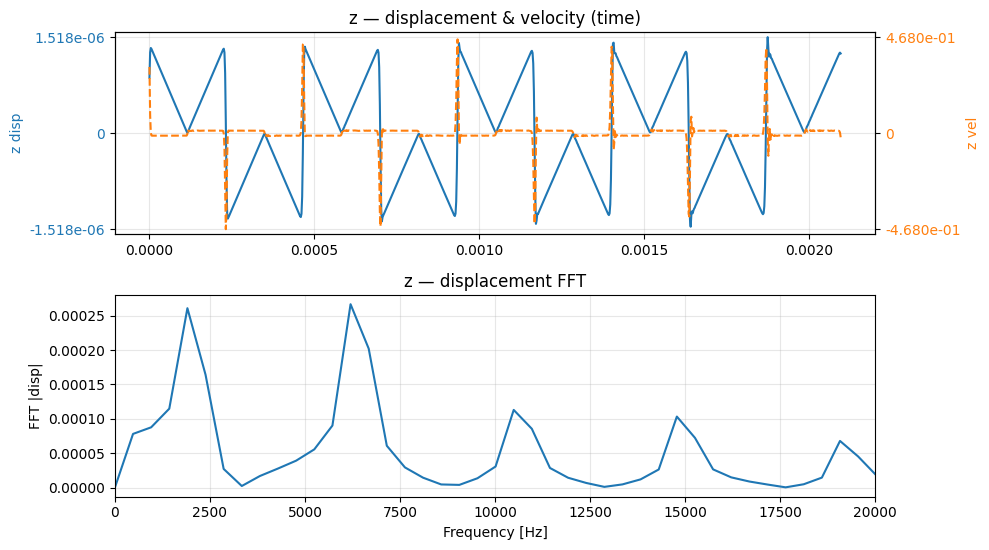

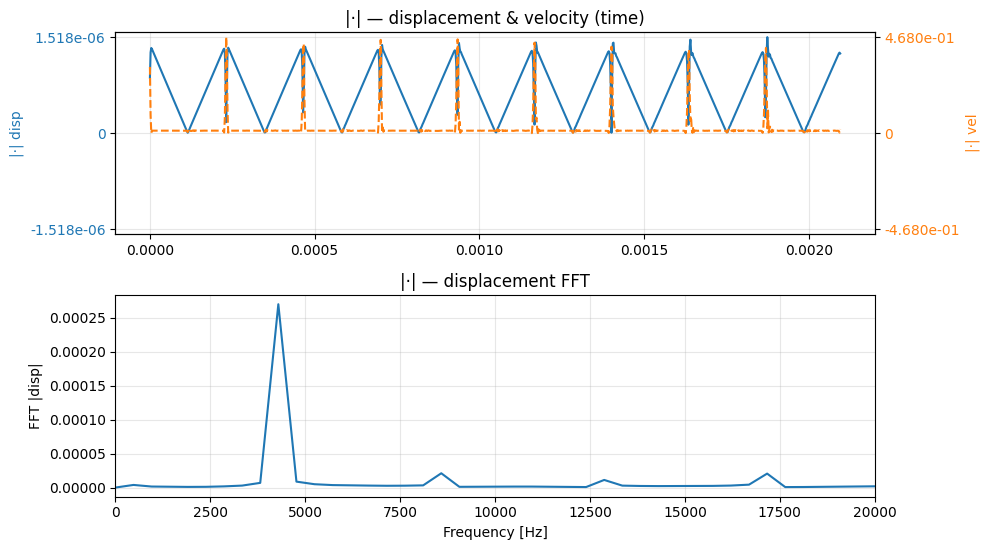

In [192]:
plot_node_pos_vel_moment_fft(frames, nodes, dt, oversampling_factor)

In [193]:
import numpy as np
import sounddevice as sd

def play_rod_displacement_as_audio(nodes_over_time, 
                                   component='z', 
                                   node_index=None, 
                                   sample_rate=44100):
    """
    Play a rod displacement as audio.

    Args:
        nodes_over_time : list of node snapshots over time
            each snapshot is list of tuples [(pos, vel), ...]
        component : 'x', 'y', 'z' or 'abs'
        node_index : int, which node to use; None = center node
        sample_rate : audio sample rate in Hz
    """
    comp_map = {'x': 0, 'y': 1, 'z': 2, 'abs': None}
    
    if component not in comp_map:
        raise ValueError("component must be 'x','y','z','abs'")

    node_count = len(nodes_over_time[0])
    if node_index is None:
        node_index = node_count // 2  # center node

    # Extract displacement over time
    disp = []
    for snapshot in nodes_over_time:
        pos, _, _ = snapshot[node_index]
        if component == 'abs':
            val = np.linalg.norm(pos)
        else:
            val = pos[comp_map[component]]
        disp.append(val)
    
    disp = np.array(disp, dtype=np.float32)

    # Normalize to [-1,1]
    disp -= disp.mean()
    max_val = np.max(np.abs(disp))
    if max_val > 0:
        disp /= max_val

    # Resample to match sample rate if needed
    from scipy.signal import resample
    n_samples = len(disp)
    duration = n_samples / sample_rate
    audio = resample(disp, int(duration * sample_rate))

    # Play audio
    sd.play(audio, samplerate=sample_rate)
    sd.wait()


In [186]:
fs = 1.0 / (dt * oversampling_factor)
print(fs)
play_rod_displacement_as_audio(frames, component='z', sample_rate=fs)

488281.24999999994


PortAudioError: Error opening OutputStream: Invalid sample rate [PaErrorCode -9997]